# TI Calculation


## Imports

In [1]:
#for analysis
from matplotlib import pyplot as plt
%matplotlib inline

import os
import numpy as np
from pygromos.files.gromos_system import Gromos_System
from pygromos.simulations.hpc_queuing.submission_systems.local import LOCAL as subSystem
from pygromos.files.blocks.imd_blocks import PERTURBATION, WRITETRAJ, DISTANCERES

from pygromos.utils import bash

## Input files

In [2]:
root_dir = os.path.abspath("example_files/TI_Calculation")
root_in_dir = root_dir+"/TI_input"
cnf_path = root_in_dir+"/M030_6KET.cnf"
top_path = root_in_dir + "/M030_6KET.top"
disres_path = root_in_dir+"/M030_6KET.disres"


sys_name = "M030_to_6KET"
lam = 0

project_dir = bash.make_folder(root_dir+"/"+sys_name)
input_dir = bash.make_folder(project_dir+"/input")

## Vacuum Simulation

### Direction A->B

#### Setup:


##### Build pertubation file


In [ ]:
from pygromos.files.topology.ptp import Pertubation_topology
from pygromos.files.blocks.topology_blocks import pertubation_lam_state, atom_lam_pertubation_state, PERTATOMPARAM, TITLE


#External imd_changes:
grom_system = Gromos_System(in_cnf_path=cnf_path, in_top_path=top_path,
                            in_disres_path=disres_path,
                            system_name=sys_name, work_folder=input_dir)


#Build up lambda - States
pert_atoms=[]
for atom_line in grom_system.top.SOLUTEATOM:
    states = {}
    phys_state = pertubation_lam_state(IAC=atom_line.IAC, MASS=atom_line.MASS, CHARGE=atom_line.CG)
    states = {atom_line.MRES: phys_state }

    pert_atom = atom_lam_pertubation_state(atom_line.ATNM,RES=atom_line.MRES,NAME=atom_line.PANM, STATES=states)
    pert_atoms.append(pert_atom)
pert_atom_block = PERTATOMPARAM(pert_atoms)

# Generate ptp file
grom_system.ptp = Pertubation_topology(in_value = None)
grom_system.ptp.PERTATOMPARAM = pert_atom_block
grom_system.ptp.TITLE = TITLE("Automatic generated pertubation file. ")

grom_system.ptp

In [ ]:
##Write out all generated files
grom_system.rebase_files()
grom_system.work_folder = project_dir

##save Input System
grom_system.save(project_dir+"/initial_startSys.obj")
grom_system

### RUN Emin

In [ ]:
# PREPARE EMIN
## IMPORT
from pygromos.data.simulation_parameters_templates import template_emin_vac
from pygromos.simulations.modules.preset_simulation_modules import emin

step_name  = "a_emin" #also the dir_name, out prefix etc.
grom_system = Gromos_System.load(project_dir+"/initial_startSys.obj")
grom_system.imd = template_emin_vac #read template imd

#Pertubation for molecules to sim params
pert_block  =  PERTURBATION(NTG=1, NRDGL=0, RLAM=lam, DLAMT=0,
                            ALPHC=0.5, ALPHLJ=0.5, NLAM=2, NSCALE=0)
grom_system.imd.add_block(block=pert_block)

#add Distance Res:
disres_block = DISTANCERES(NTDIR=1, TAUDIR=1,)
grom_system.imd.add_block(block=disres_block)

In [ ]:
#EXECUTE EMIN
emin_gromos_system = emin(in_gromos_system=grom_system, 
                          step_name=step_name, submission_system=subSystem())

emin_gromos_system.save(project_dir+"/emin_out.obj")
emin_gromos_system

## RUN Test SD EQ

In [ ]:
from pygromos.data.simulation_parameters_templates import template_sd
from pygromos.simulations.modules.preset_simulation_modules import sd

step_name  = "b_vacuum_sd"
grom_system = emin_gromos_system
grom_system.system_name = step_name
grom_system.imd = template_sd

#Pertubation
pert_block  =  PERTURBATION(NTG=1, NRDGL=0, RLAM=lam, DLAMT=0,
                            ALPHC=0.5, ALPHLJ=0.5, NLAM=2, NSCALE=0)
grom_system.imd.add_block(block=pert_block)


#add Distance Res:
disres_block = DISTANCERES(NTDIR=1, TAUDIR=1,)
grom_system.imd.add_block(block=disres_block)


#write out trajs:
write_traj = WRITETRAJ(NTWX=100, NTWE=100)
grom_system.imd.add_block(block=write_traj)

#further mods:
grom_system.imd.CONSTRAINT.NTC = 3
grom_system.imd.FORCE.BONDS = 0

grom_system.imd.STEP.NSTLIM = 30000


In [ ]:
sd_gromos_system  = sd(in_gromos_system=grom_system, step_name=step_name,
                              submission_system=subSystem(), equilibration_runs=1, simulation_runs=1)
sd_gromos_system.save(project_dir+"/sd_out_system.obj")
sd_gromos_system

## Further Analysis:

In [ ]:
#final analysis dir:
from pygromos.utils import bash

out_ana = project_dir+"/c_ana"
if(not os.path.exists(out_ana)):
    bash.make_folder(out_ana)

### Coordinate analysis

In [ ]:
from pygromos.files.coord import Cnf
in_path=project_dir+"/a_emin/analysis/data/a_emin.cnf"
cnf_file = Cnf(in_path)
cnf_file.write_pdb(in_path.replace("cnf", "pdb"))


In [ ]:
cnf_file.view

In [ ]:
from pygromos.files.trajectory.trc import Trc

in_path=project_dir+"/b_vacuum_sd/analysis/data/b_vacuum_sd.trc.h5"

trc = Trc(traj_path=in_path, in_cnf=cnf_file)
trc.write(out_ana+"/sd_traj.pdb")#grom_system.cnf.path)
trc

In [ ]:
trc.view


### Energy analysis

In [ ]:
from pygromos.files.trajectory.tre import Tre

in_path=project_dir+"/b_vacuum_sd/analysis/data/b_vacuum_sd.tre.h5"

tre = Tre(input_value=in_path)
tre



In [ ]:
#Plot Potential Energies
V_tot = np.array(list(map(lambda x: x[2], tre.database.totals)))
step = len(tre.database.time)//10

plt.plot(tre.database.time, V_tot)
plt.xticks(np.round(list(tre.database.time[::step]),2))
plt.xlabel("$t~[ps]$")
plt.ylabel("$V~[kJ]$")
plt.title("V total timeseries")
plt.savefig(out_ana+"/potential_energy_timeseries.png")



## Lambda Sampling

### Setup again

In [ ]:
import os
import numpy as np
from pygromos.files.gromos_system import Gromos_System
from pygromos.simulations.hpc_queuing.submission_systems.local import LOCAL as subSystem

from pygromos.utils import bash
sys_name = "M030_to_6KET"

sd_gromos_system.imd.WRITETRAJ.NTWG =  sd_gromos_system.imd.WRITETRAJ.NTWX = sd_gromos_system.imd.WRITETRAJ.NTWE =10
sd_gromos_system.imd.STEP.NSTLIM = 100

sd_gromos_system

## Submission

In [ ]:
from pygromos.simulations.modules.ti_modules import TI_sampling

step_name  = "d_lambda_sampling"
sd_gromos_system.name = step_name


TI_sampling(in_gromos_system = sd_gromos_system, step_name=step_name,
            lambda_values= np.arange(0, 1.2, 0.2), 
            subSystem=subSystem(), n_productions=3, n_equilibrations = 1)


## Free Energy Calculation:


In [43]:
#read in trgs files for free energy data:
import glob
from matplotlib import pyplot as plt
from pygromos.files.trajectory.trg import Trg


step_name  = "d_lambda_sampling"
path = project_dir+"/"+step_name

trg_paths = sorted(glob.glob(path+"/*/analysis/data/*trg.h5"), key=lambda x: float("".join(x.split("_")[-1].split(".")[1])))
trg_paths.append(trg_paths.pop(0))
trgs = [Trg(tre_path) for tre_path in trg_paths]


In [44]:
# get lambda window values:
lams = [float(trg.get_lambdas().iloc[0]) for trg in trgs]
dhdl_means = [float(trg.get_totals()["dHdl"].mean()) for trg in trgs]

lams, dhdl_means

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 [168.82322894333328,
  137.4148451066667,
  73.05525409,
  -19.786582800666668,
  -136.67749508999998,
  -279.17949676666666,
  -452.3749407733334,
  -653.6861703466668,
  -850.4159182666665,
  -956.7124365533332,
  -873.2767645733333])

### TI - Integration Curve

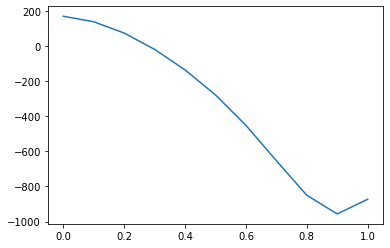

In [45]:
plt.plot(lams, dhdl_means)

### Calculate Integration

In [46]:
from scipy.integrate import simpson
dF = simpson(y=dhdl_means, x=lams)
dF

-350.83597003842226

In [ ]:
#  To Be implemented!